In [23]:
import pandas as pd
import sqlite3
from sqlite3 import Error
import os


#Variable Section

table ="TeacherPay4"
contable ="ConTPay"
cwd=os.getcwd()
datafolder='StateOESDatasets'
database = 'TeacherSalary.db'
#ss_xls = os.path.join(cwd,datafolder,datafile) #path of .xls files
ss_db = os.path.join(cwd,database)

conn = sqlite3.connect(ss_db,isolation_level=None)
cur = conn.cursor()

#SQL Statements

TeacherPay_table_sql = """CREATE TABLE IF NOT EXISTS ? (id integer Primary Key, 
                                                                    ST text,
                                                                    STATE text,
                                                                    OCC_CODE text,
                                                                    OCC_TITLE text,
                                                                    TOT_EMP int,
                                                                    A_MEAN int,
                                                                    A_MEDIAN int,
                                                                    year int);.teacher"""




ConsolidatedTeacherPay_table_sql = "CREATE TABLE IF NOT EXISTS ConTPay (id integer Primary Key autoincrement ,ST TEXT, STATE text, OCC_CODE text, OCC_TITLE text, TOT_EMP real, A_MEAN real, A_MEDIAN real, year integer);"
,
ConsolidatedTeacherPay_insert_sql = """INSERT INTO ConTPay(ST, STATE, OCC_CODE, OCC_TITLE, TOT_EMP, A_MEAN, A_MEDIAN, year) Select ST, STATE, OCC_CODE, OCC_TITLE, TOT_EMP, A_MEAN, A_MEDIAN, year FROM TeacherPay4 WHERE OCC_Code IN ('25-2021','25-2022','25-2023','25-2031','25-2032','25-2041','25-2042','25-2043');"""

drop_table_sql = """ Drop TABLE IF EXISTS %s """ % table

drop_ConTPay_table_sql = """ Drop TABLE IF EXISTS %s """ % contable

rowCount_sql = """SELECT max(rowid) from %s"""% table

#Function Set

# Create Database function
def create_db(db_file):
    """ create a database connection to a SQLite database """
    try:

        conn = sqlite3.connect(db_file)   #create a database connection to a SQLite database
        print(sqlite3.version)    #Confirmation
        conn.close()
    except Error as e:
        print(e)
    #finally:
    #    conn.close()
    

    #create connection function
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def xlsCounter(db_file):
    wb = load_workbook(db_file, use_iterators=True)
    sheet = wb.worksheets[0]
    row_count = sheet.max_row
    print(row_count)
    #pass

    
#count roows in table function
def rowCounter(db_file):   #rows in table
    cur.execute(rowCount_sql)
    rcount = cur.fetchone()[0]
    return rcount


#import data from .xls files as DF and load into table (TeacherPay) - one xls at a time & makes own table
def xls2db(db_file,rowCounter):
    with sqlite3.connect(db_file) as conn:
        df={}    #clear dataframe
        #set record count variables
        n=0
        lisum=0
        print('Database being created.\n')
        conn.execute(drop_table_sql)    #drop table to clear it before loading
        #conn.execute(TeacherPay_table_sql)    - not needed due to df.to_sql
        print(".xls files being read and inserted into database.\n")
        for x in range(1997,2018):      #cycle through year ranges for file names
            xlsfile = 'StateOESDatasets/state_'+str(x)+'_dl.xls'  
            df = pd.read_excel(xlsfile)
                               #,converters={'TOT_EMP':int,'A_MEAN':int, 'A_MEDIAN':int},errors='ignore'  / load data
        #Clean-up Routine
            df.columns = df.columns.str.strip()    # strip whitespace from headers
            df.drop(columns= ['AREA','EMP_PRSE', 'H_MEAN', 'MEAN_PRSE','H_PCT10','H_PCT25','H_MEDIAN','H_PCT75','H_PCT90','A_PCT10','A_PCT25','A_PCT75','A_PCT90','ANNUAL'], axis=1, inplace=True)
            df['OCC_CODE'] = df['OCC_CODE'].astype('str')

            df['TOT_EMP'] = df['TOT_EMP'].astype('str')
            df['TOT_EMP'] = df['TOT_EMP'].str.replace('*', '')
            df['TOT_EMP'] = pd.to_numeric(df['TOT_EMP'], errors='coerce')
            
            df['A_MEAN'] = df['A_MEAN'].astype('str')
            df['A_MEAN'] = df['A_MEAN'].str.replace('*', '')
            df['A_MEAN'] = pd.to_numeric(df['A_MEAN'], errors='coerce')
            
            df['A_MEDIAN'] = df['A_MEDIAN'].astype('str')
            df['A_MEDIAN'] = df['A_MEDIAN'].str.replace('*', '')
            df['A_MEDIAN'] = pd.to_numeric(df['A_MEDIAN'], errors='coerce')
            
            df['year']=x                           #add Year x column (series) to datafrom
            #df.replace("NaN","")
            #df[["A_MEAN", "A_MEDIAN"]] = df[["A_MEAN", "A_MEDIAN"]].apply(pd.to_numeric, errors='ignore')
            #df = df.astype({"OCC_CODE": str},{"A_MEAN":int},{"A_MEDIAN":int})
            
            df.to_sql(table, conn, if_exists='append')    # load data into database
            
            conn.commit()

            li=lenIndex =len(df.index)              #record count of df
            print("DataFrame records from file state_"+str(x)+"_dl.xls: ",li,)

            n=rowCounter(db_file)           #record count of table function call
            print("Total records in table: ",n)

            if n - li == lisum :
                print(n," - ",li, " = ", lisum, ".  Success for "+str(x)+".\n")

            lisum+=li
            x+=1 
            

def make_ConTPay_table(db_file):
    with sqlite3.connect(db_file) as conn:
        conn.execute(drop_ConTPay_table_sql)
        conn.execute(ConsolidatedTeacherPay_table_sql)
        print('table created')
        conn.commit()
        conn.execute(ConsolidatedTeacherPay_insert_sql)
        print('inserted')

def make_TeacherPay_table(db_file):
    with sqlite3.connect(db_file) as conn:
        conn.execute(drop_TeacherPay_table_sql)
        conn.execute(TeacherPay_table_sql)
        print('table created')
        conn.commit()
        conn.execute(ConsolidatedTeacherPay_insert_sql)
        print('inserted\n\n\n  BOOYAH!')
              
#Function calls in order
#create_db(ss_db)
xls2db(ss_db,rowCounter)
make_ConTPay_table(ss_db)

Database being created.

.xls files being read and inserted into database.

DataFrame records from file state_1997_dl.xls:  34433
Total records in table:  34433
34433  -  34433  =  0 .  Success for 1997.

DataFrame records from file state_1998_dl.xls:  35700
Total records in table:  70133
70133  -  35700  =  34433 .  Success for 1998.

DataFrame records from file state_1999_dl.xls:  30447
Total records in table:  100580
100580  -  30447  =  70133 .  Success for 1999.

DataFrame records from file state_2000_dl.xls:  33192
Total records in table:  133772
133772  -  33192  =  100580 .  Success for 2000.

DataFrame records from file state_2001_dl.xls:  33000
Total records in table:  166772
166772  -  33000  =  133772 .  Success for 2001.

DataFrame records from file state_2002_dl.xls:  32406
Total records in table:  199178
199178  -  32406  =  166772 .  Success for 2002.

DataFrame records from file state_2003_dl.xls:  32355
Total records in table:  231533
231533  -  32355  =  199178 .  Su


We will create a graph that compares Teacher Pay Trends Over the Last 20 Years.

Use 2 character abbreviateions to choose 5 states to compare.

State 1: KY
State 2: TN
State 3: CA
State 4: LA
State 5: MA
('KY', 'TN', 'CA', 'LA', 'MA')
             STATE  year   A_MEAN
0       California  1999  45270.0
1       California  1999  44810.0
2       California  1999  39990.0
3       California  1999  47580.0
4       California  1999  50410.0
5       California  1999  47420.0
6       California  1999  46940.0
7       California  1999  51070.0
8         Kentucky  1999  35720.0
9         Kentucky  1999  34660.0
10        Kentucky  1999  35690.0
11        Kentucky  1999  35640.0
12        Kentucky  1999  37870.0
13        Kentucky  1999  33630.0
14        Kentucky  1999  33470.0
15        Kentucky  1999  34980.0
16       Louisiana  1999  35560.0
17       Louisiana  1999  20000.0
18       Louisiana  1999  32190.0
19       Louisiana  1999  34650.0
20       Louisiana  1999  16750.0
21       Louisia

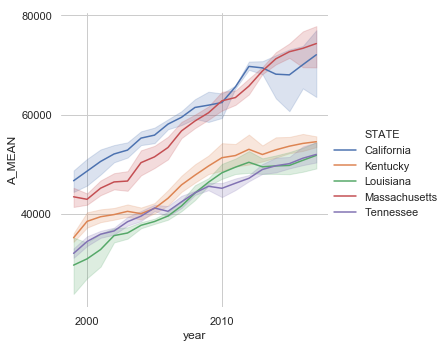

In [24]:
#VIOLIN PLOT BASE
import pandas as pd
import os
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


#Variables

contable ="ConTPay"
cwd=os.getcwd()
database = 'TeacherSalary.db'
ss_db = os.path.join(cwd,database)
conn = sqlite3.connect(ss_db,isolation_level=None)
cur = conn.cursor()
#OCC_Code_Choice=()


#SQL
ContTPay_1st_sql = """SELECT STATE , year, A_MEAN FROM ConTPay WHERE ST in {} ;"""

def output_script():
    print('\nWe will create a graph that compares Teacher Pay Trends Over the Last 20 Years.\n\nUse 2 character abbreviateions to choose 5 states to compare.\n')
    ST1 = input("State 1: ")
    ST2 = input("State 2: ")
    ST3 = input("State 3: ")
    ST4 = input("State 4: ")
    ST5 = input("State 5: ")
    State5 = (ST1,ST2,ST3,ST4,ST5)
    print(State5)
    return State5 

# Load dataset
def SQL_to_DF(State5):
    with sqlite3.connect(ss_db) as conn:
        df={}
        df=pd.read_sql(ContTPay_1st_sql.format(State5), conn)
        print(df)
        return df
        


State5=output_script()
df=SQL_to_DF(State5)
             


#ax =sns.catplot(x='STATE', y='A_MEAN',hue = 'year', kind="line", data=df)
sns.relplot(x="year", y="A_MEAN",  kind="line",hue = 'STATE', data=df)
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Finalize the figure
#ax.set(ylim=(-.7, 1.05))
sns.despine(left=True, bottom=True)

#if __name__== "__main__":  main()


In [ ]:
import seaborn as sns
import numpy as np
import matplotlib as mpl
import scipy as sp
import pandas as pd



print("Seaborn", sns.__version__,"\nNumpy",np.__version__,"\nMatPlotLib",mpl.__version__,"\nScipy",sp.__version__,"\nPandas",pd.__version__ )